<a href="https://colab.research.google.com/github/kieranfmaguire/learningdeeplearning/blob/main/notebooks/generate_text_with_RNN_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Shakespearean Text Using a Character RNN
---
Based on example in chapter 16 - Hands on Machine Learnings with Scikitlearn and Tensorflow (O'Reilly)

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Downloading some data
---

In [2]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespear.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

print(f"shakespeare_text is a: {type(shakespeare_text)}")
print(f"shakespeare_text has length: {len(shakespeare_text)}")
print(f"First 500 characters are:\n\n{shakespeare_text[:500]}")

1122304/1115394 [==============================] - 0s 0us/step
shakespeare_text is a: <class 'str'>
shakespeare_text has length: 1115394
First 500 characters are:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## Tokenizing the text data - each unique character is given a unique ID
---

In [3]:
tokeniser = tf.keras.preprocessing.text.Tokenizer(char_level=True)   # char level creates unique id for each charater (default is by word)
tokeniser.fit_on_texts(shakespeare_text)  # assigns ID (starting at 1) for each unique character
num_unique_chars = len(tokeniser.word_index)
num_chars = tokeniser.document_count    # will need this later for one hot encoding

print(f"Number of distinct characters: {len(tokeniser.word_index)}")
print(f"Total number of characters in documents: {num_chars}")




Number of distinct characters: 39
Total number of characters in documents: 1115394


In [4]:
# now encode the entire text, split into train and test, and create tf.data.Dataset object
encoded = np.array(tokeniser.texts_to_sequences([shakespeare_text])).flatten()

train_size = int(encoded.shape[0] * 0.2)    # use 20% for train
test_size = int(encoded.shape[0] * 0.2)     # use 20% for test (help with early stopping)
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset_val = tf.data.Dataset.from_tensor_slices(encoded[-train_size:])

### To train the model, will use sub-sequences of length `n_steps`
---
the tensorflow datasets API can handle this with the window method

In [5]:
n_steps = 100                   # number of characters in a given instance
window_length = n_steps + 1     # we will predict the next character in the sequence, so will need it as the target
batch_size = 32                 # batch size for gradient descent

In [6]:
dataset = dataset.window(size=window_length, shift=1, stride=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))

dataset_val = dataset_val.window(size=window_length, shift=1, stride=1, drop_remainder=True)
dataset_val = dataset_val.flat_map(lambda window: window.batch(window_length))


In [7]:
# have a look at the structure
for i, dat in enumerate(dataset):
    print(dat)
    if i > 0: break

tf.Tensor(
[20  6  9  8  3  1 19  6  3  6 36  2 10 24 11 22  2 20  4  9  2  1 17  2
  1 23  9  4 19  2  2 13  1  5 10 16  1 20 14  9  3  7  2  9 18  1  7  2
  5  9  1 15  2  1  8 23  2  5 25 27 11 11  5 12 12 24 11  8 23  2  5 25
 18  1  8 23  2  5 25 27 11 11 20  6  9  8  3  1 19  6  3  6 36  2 10 24
 11 16  4 14  1], shape=(101,), dtype=int64)
tf.Tensor(
[ 6  9  8  3  1 19  6  3  6 36  2 10 24 11 22  2 20  4  9  2  1 17  2  1
 23  9  4 19  2  2 13  1  5 10 16  1 20 14  9  3  7  2  9 18  1  7  2  5
  9  1 15  2  1  8 23  2  5 25 27 11 11  5 12 12 24 11  8 23  2  5 25 18
  1  8 23  2  5 25 27 11 11 20  6  9  8  3  1 19  6  3  6 36  2 10 24 11
 16  4 14  1  5], shape=(101,), dtype=int64)


In [8]:
# shuffle, batch, then split into fetaures and target
dataset = dataset.shuffle(int(1e3)).batch(batch_size)
dataset = dataset.map(lambda x: (x[:, :-1], x[:, 1:]))   
# one hot encode the categorical features - small enough dictionary for this to be reasonable. 
# in general this would usually be an embedding
dataset = dataset.map(lambda x, y: (tf.one_hot(x, depth=num_unique_chars), y))
dataset = dataset.prefetch(1) # don't really need to worry about prefetching on this small dataset

dataset_val = dataset_val.batch(batch_size)\
  .map(lambda x: (x[:, :-1], x[:, 1:]))\
  .map(lambda x,y: (tf.one_hot(x, depth=num_unique_chars), y))

In [9]:
for x,y in dataset.take(1):
  print(x)
  print(y)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

## Now we can create a model
---

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(units=128, input_shape=[None, num_unique_chars], return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.GRU(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=num_unique_chars, activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=['sparse_categorical_crossentropy']
              )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 128)         64896     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 39)          5031      
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(dataset, epochs=4, validation_data=dataset_val, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)], verbose=2)

Epoch 1/4
6969/6969 - 4316s - loss: 1.6142 - sparse_categorical_crossentropy: 1.6142 - val_loss: 2.1134 - val_sparse_categorical_crossentropy: 2.1134
Epoch 2/4
6969/6969 - 4198s - loss: 1.4270 - sparse_categorical_crossentropy: 1.4270 - val_loss: 2.0876 - val_sparse_categorical_crossentropy: 2.0876
Epoch 3/4
6969/6969 - 4373s - loss: 1.3829 - sparse_categorical_crossentropy: 1.3829 - val_loss: 2.0652 - val_sparse_categorical_crossentropy: 2.0652
Epoch 4/4
6969/6969 - 4112s - loss: 1.3605 - sparse_categorical_crossentropy: 1.3605 - val_loss: 2.0590 - val_sparse_categorical_crossentropy: 2.0590


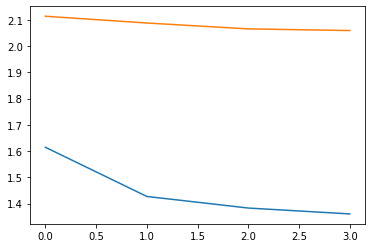

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Create some utility functions to help generate text
---

In [18]:
def preprocess(text):
  return tf.one_hot(np.array(tokeniser.texts_to_sequences([text])), depth=num_unique_chars)

def next_char(text):
  processed = preprocess(text)
  return tf.math.argmax(model.predict(processed), axis=-1)[:,-1:]

def next_char_rand(text, temp):
  processed = preprocess(text)
  probs = model.predict(processed)[0,-1:,:]
  log_probs_rescaled = tf.math.log(probs) / temp
  return tf.random.categorical(log_probs_rescaled, 1)

def decode(encoded):
  return tokeniser.sequences_to_texts(encoded.numpy())

def generate_text(starting_text, n, temp):
  text = starting_text
  for _ in range(n):
    new_char = decode(next_char_rand(text, temp))[0]
    text += new_char
  return text

In [29]:
new_txt = generate_text('hello', 100, 0.5)
print(new_txt)

hellows and made the way
the cousin, my son of your gracious
and faith of your cousin, i'll go welcome,
t
